## Dati ISTAT agricoltura

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import altair as alt
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import HBox, VBox, Layout
import warnings
warnings.filterwarnings("ignore")

# dati ISTAT
data = pd.read_csv("DCSP_COLTIVAZIONI_22032024191007716.csv")

# Rimozione spazi bianchi dopo le stringhe della colonna 'Tipo dato'
data['Tipo dato'] = data['Tipo dato'].str.rstrip()

# Filtro 'Tipo dato' di interesse
data_filtered = data[data["Tipo dato"].isin(['superficie totale - ettari', 'superficie totale - are', 
                                           'superficie in produzione - ettari', 'produzione totale - quintali', 
                                           'produzione totale - migliaia di quintali', 'produzione raccolta - quintali',
                                            'unità foraggere', 'superficie in produzione - ettari'])]

# Filtro 'Territorio' di interesse
data_filtered = data_filtered[data_filtered["Territorio"].isin(['Italia', 'Liguria', 'Lombardia',
                                             'Trentino Alto Adige / Südtirol', 'Veneto', 
                                             'Friuli-Venezia Giulia', 'Emilia-Romagna', 
                                             'Toscana', 'Umbria', 
                                             'Marche', 'Lazio', 
                                             'Campania', 'Puglia',  
                                             'Calabria', 'Sicilia',
                                             'Sardegna', 'Abruzzo', 
                                             'Basilicata', 'Molise', 
                                             "Valle d'Aosta / Vallée d'Aoste", 
                                             'Bolzano / Bozen', 'Piemonte'])]
                                             
data_filtered2 = data_filtered
column_of_interest = ['Tipo dato', 'Tipo di coltivazione', 'TIME', 'Value', 'Territorio']
data_filtered3 = data_filtered2[column_of_interest]

Droppo le righe che fanno sballare le somme

In [3]:
rows_to_delete = ['grano invernale e farro', 'grano primaverile e farro', 'orzo invernale, orzo primaverile',
                     'uve per vini dop', 'uve per vini igp', 'uve per altri vini (escluso dop e igp)', 'olive da tavola', 
                     'altre olive', 'olive da olio', 'limoni e lime acidi', 'champignons', 
                     'altri funghi coltivati diversi dagli champignons']

In [4]:
# Filtro via le righe che non mi interessano
data_filtered3 = data_filtered3[~data_filtered3["Tipo di coltivazione"].isin(rows_to_delete)]

#### Grafico interattivo con altair

Ho creato un grafico interattivo con due menù a tendina, uno per la selezione del tipo di dato e uno per la selezione del territorio (ho messo solo le regioni di Italia). Il grafico mostra i valori del tipo dato selezionato per il territorio selezionato per ogni anno dal 2006 al 2023.

In [3]:
import pandas as pd
import altair as alt
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import VBox, HBox

# Calcolo valore totale per Tipo dato e TIME
summarized_df = data_filtered3.groupby(['Tipo dato', 'TIME', 'Territorio'])['Value'].sum().reset_index()

# Rimozione anno 2024 perchè mancano dei dati
summarized_df = summarized_df[summarized_df['TIME'] != 2024]

df = summarized_df

# Dropdown options
dropdown_options1 = sorted(df['Tipo dato'].unique().tolist())
dropdown_options2 = sorted(df['Territorio'].unique().tolist())

# Function to update chart based on selected Tipo dato and Territorio
def update_chart(Tipo_dato, Territorio):
    filtered_df = df[(df['Tipo dato'] == Tipo_dato) & (df['Territorio'] == Territorio)]
    
    # Compute maximum value for each group
    max_values = filtered_df.groupby(['Tipo dato', 'Territorio'])['Value'].max()
    min_values = filtered_df.groupby(['Tipo dato', 'Territorio'])['Value'].min()

    # Set padding for the y-axis
    padding = 10000  # You can adjust the padding as needed
    
    # Line connecting the points with a darker blue color
    line = alt.Chart(filtered_df).mark_line().encode(
        x=alt.X('TIME:N', title='Time'),
        y=alt.Y('Value:Q', title='Value', scale=alt.Scale(domain=(0, max_values.max() + padding))),  # Adjusted y-axis scale
        color=alt.value('#1f77b4')  # Darker blue color for the line
    )
    
    # Scatter plot with circles
    chart = alt.Chart(filtered_df).mark_circle().encode(
        x=alt.X('TIME:N', title='Time'),
        y=alt.Y('Value:Q', title='Value'),  # Y-axis scale will be adjusted for each group
        size=alt.Size('Value:Q', bin=alt.BinParams(maxbins=5), legend=None),
        color=alt.Color('Value:Q', scale=alt.Scale(domain=(min_values.min(), max_values.max()), range=['#66c2a4', '#005824'])),  # Custom green color range with darker green
        tooltip=['TIME:N', 'Value:Q']
    ).properties(
        width=600,
        height=400,
        title=Tipo_dato + ' ' + Territorio
    )

    combined_chart = alt.layer(line, chart)
    
    # Clear previous output and display the updated chart
    with output:
        clear_output(wait=True)
        display(combined_chart)

# Dropdown widgets
dropdown_tipo_dato = widgets.Dropdown(
    options=dropdown_options1,
    value=dropdown_options1[0],  # Set initial value
    description='Select Tipo dato:',
    style={'description_width': 'initial'}  # Set description width to full
)

dropdown_territory = widgets.Dropdown(
    options=dropdown_options2,
    value=dropdown_options2[7],  # Set initial value
    description='Select Territory:',
    style={'description_width': 'initial'}  # Set description width to full
)

# Output widget to display the chart
output = widgets.Output()

# Function to handle dropdown changes and update the chart
def on_dropdown_change(change):
    selected_tipo_dato = dropdown_tipo_dato.value
    selected_territory = dropdown_territory.value
    update_chart(selected_tipo_dato, selected_territory)

# Observe changes in dropdowns and trigger chart update
dropdown_tipo_dato.observe(on_dropdown_change, names='value')
dropdown_territory.observe(on_dropdown_change, names='value')

# Display the dropdowns and initial chart
display(VBox([dropdown_tipo_dato, dropdown_territory]))
update_chart(dropdown_tipo_dato.value, dropdown_territory.value)

# Display the output widget containing the chart
display(output)

Output()

Ho creato due grafici interattivi per mettere a confronto il contributo di ogni singola coltivazione selezionando due anni differenti per capire il divario che c'è tra alcuni anni.

In [2]:
# Selezione del territorio di interesse
Territorio = 'Italia'

# Selezione degli attributi che si vogliono osservare
attributo_1 = 'superficie totale - ettari'
attributo_2 = 'produzione totale - quintali'
#attributo_1 = 'produzione totale - quintali'
#attributo_2 = 'produzione raccolta - quintali'
#attributo_1 = 'superficie totale - ettari'
#attributo_2 = 'superficie in produzione - ettari'
data_filtered4 = data_filtered3[data_filtered3['Tipo dato'] == attributo_1]
data_filtered5 = data_filtered4[data_filtered4['Territorio'] == Territorio]
data_filtered5

total_by_year = data_filtered5.groupby('TIME')['Value'].transform('sum')
data_filtered5['Percentage'] = (data_filtered5['Value'] / total_by_year) * 100
data_filtered5['Percentage'] = data_filtered5['Percentage'].round(2)
df_sorted = data_filtered5.sort_values(by = 'Percentage', ascending=False)
df_sorted_filtered = df_sorted[df_sorted['Percentage'] > 1.00]
#df_sorted_filtered = df_sorted
df_sorted_filtered = df_sorted_filtered[df_sorted_filtered['TIME'] != 2024]
df_sorted_filtered

# Sample DataFrame with longer category names
df = df_sorted_filtered

# Dropdown options (list of TIME)
dropdown_options = sorted(df['TIME'].unique().tolist())

# Function to update chart1 based on selected category
def update_chart1(TIME1):
    filtered_df = df[df['TIME'] == TIME1]
    chart = alt.Chart(filtered_df).mark_bar(color = 'blue').encode(
        x = 'Tipo di coltivazione',
        y = 'Value',
        #y = alt.Y('Percentage', scale=alt.Scale(domain=(0, df_sorted_filtered['Percentage'].max()+1))),
        tooltip=['Tipo di coltivazione', 'Value']
    ).properties(
        width=400,
        height=300,
        title = 'superficie totale - ettari'
     )
    display(chart)

# Function to update chart2 based on selected year
def update_chart2(TIME2):
    filtered_df = df[df['TIME'] == TIME2]
    chart = alt.Chart(filtered_df).mark_bar(color = 'orange').encode(
        x = 'Tipo di coltivazione',
        y = 'Value',
        #y = alt.Y('Percentage', scale=alt.Scale(domain=(0, df_sorted_filtered['Percentage'].max()+1))),
        tooltip=['Tipo di coltivazione', 'Value']
    ).properties(
        width=400,
        height=300,
        title = 'superficie totale - ettari'
     )
    display(chart)

dropdown_category = widgets.Dropdown(
    options=dropdown_options,
    value=dropdown_options[0],  # Set initial value
    description='Select Year:',
    style={'description_width': 'initial'}  # Set description width to full
)

# Dropdown widget for selecting year
dropdown_year = widgets.Dropdown(
    options=dropdown_options,
    value=dropdown_options[1],  # Set initial value
    description='Select Year:',
    style={'description_width': 'initial'}  # Set description width to full
)

# Initial display of charts and dropdowns side by side
output1 = widgets.Output()
output2 = widgets.Output()

with output1:
    display(VBox([dropdown_category]))
    update_chart1(dropdown_category.value)

with output2:
    display(VBox([dropdown_year]))
    update_chart2(dropdown_year.value)

# Arrange the outputs (charts) horizontally using HBox layout
display(HBox([output1, output2]))

# Set up event handlers for dropdowns
def on_category_change(change):
    with output1:
        clear_output(wait=True)
        display(VBox([dropdown_category]))
        update_chart1(change.new)

def on_year_change(change):
    with output2:
        clear_output(wait=True)
        display(VBox([dropdown_year]))
        update_chart2(change.new)

dropdown_category.observe(on_category_change, names='value')
dropdown_year.observe(on_year_change, names='value')

#### Questo penso sia l'unico modo per mettere il grafico con il menù a tendina dentro un sito web html

In [5]:
# Calcolo valore totale per Tipo dato e TIME
summarized_df = data_filtered3.groupby(['Tipo dato', 'TIME', 'Territorio'])['Value'].sum().reset_index()

# Rimozione anno 2024 perchè mancano dei dati
summarized_df = summarized_df[summarized_df['TIME'] != 2024]

# Create a new column for the concatenated title
summarized_df['Title'] = summarized_df['Tipo dato'] + ' - ' + summarized_df['Territorio']

# Dropdown options (list of Tipo dato)
dropdown_options1 = sorted(summarized_df['Tipo dato'].unique().tolist())

# Dropdown options (list of Territories)
dropdown_options_territorio = sorted(summarized_df['Territorio'].unique().tolist())

# Dropdown selection
dropdown1 = alt.binding_select(options=dropdown_options1, name = 'Select Tipo dato ')
selection1 = alt.selection_point(fields=['Tipo dato'], bind=dropdown1, name='SelectTipoDato', value = dropdown_options1[0])

# Dropdown selection
dropdown2 = alt.binding_select(options=dropdown_options_territorio, name = 'Select Territorio ')
selection2 = alt.selection_point(fields=['Territorio'], bind=dropdown2, name = 'SelectTerritorio', value = dropdown_options_territorio[7])

min_max_values = summarized_df.groupby(['Tipo dato', 'Territorio'])['Value'].agg(['min', 'max']).reset_index()

import altair as alt
import pandas as pd
import base64
from io import BytesIO
from PIL import Image

# Funzione per convertire l'immagine in una stringa base64
def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Converti l'immagine locale in base64
image_path = "plot.png"
base64_image = image_to_base64(image_path)
image_url = f"data:image/png;base64,{base64_image}"

# Grafico a dispersione con cerchi
chart = alt.Chart(summarized_df).transform_filter(
    selection1 & selection2
).mark_circle().encode(
    y='Value:Q',
    x='TIME:N',
    size=alt.Size(field='Value', type='quantitative', bin=alt.BinParams(maxbins=5)),
    color=alt.Color('Value:Q', scale=alt.Scale(scheme='blues')),
    tooltip=['TIME', 'Value']
).encode(
    x=alt.X('TIME:N', title='Time', axis=alt.Axis(labelAngle=0, labelAlign='center', labelBaseline='top')),
    y=alt.Y('Value:Q', title='Value'),
    size=alt.Size('Value:Q', scale=alt.Scale(range=[20, 300]), legend = None),  # Binning dei pallini
    color=alt.Color('Value:Q', scale=alt.Scale(range=['#66c2a4', '#005824'])),
    tooltip=['TIME:N', 'Value:Q']
).properties(
    width=600,
    height=400
)

# Grafico a linee
line = alt.Chart(summarized_df).transform_filter(
    selection1 & selection2
).mark_line().encode(
    x=alt.X('TIME:N', title='Time'),
    y=alt.Y('Value:Q', title='Value'),
    color=alt.value('#5F9EA0')  # Colore blu più scuro per la linea
)

# Text chart for dynamic title
text = alt.Chart(summarized_df).transform_filter(
    selection1 & selection2
).mark_text(
    align='center',
    dy=-15,
    fontSize=20
).encode(
    text='Title:N'
).properties(
    width=600,
    height=30  # Height for the text chart
)


# Combine text chart and main chart
combined_chart = alt.vconcat(text, alt.layer(line, chart).add_selection(selection2, selection1))


# combined_chart = alt.layer(line, chart)

# Save the chart to a JSON file
chart_json = combined_chart.to_json()
with open('chart.json', 'w') as f:
    f.write(chart_json)

# Visualizzazione del grafico combinato
combined_chart

alt.VConcatChart(...)

In [20]:
summarized_df2 = summarized_df[summarized_df['TIME'] == 2020]
summarized_df2 = summarized_df2[summarized_df2['Tipo dato'] == 'produzione raccolta - quintali']
summarized_df3 = summarized_df2[summarized_df2['Territorio'] != 'Italia']
summarized_df3['Value'].sum()
#summarized_df2

1576106290.0

In [23]:
data_filtered3['Tipo di coltivazione'].unique()

array(['cicoria o radicchio in serra', 'sedano in piena aria',
       'cavolo cappuccio in piena aria', 'cavolo di bruxelles',
       'cavolo verza', 'peperone in serra',
       'cetriolo da mensa in piena aria',
       'cetriolo da sottaceti in piena aria', 'popone o melone in serra',
       'popone o melone in piena aria', 'zucchina in serra',
       'zucchina in piena aria', 'cocomero in piena aria',
       'finocchio in serra', 'indivia in serra', 'prezzemolo in serra',
       'ravanello in piena aria', 'spinacio in piena aria',
       'altri cavoli in piena aria', 'cavolfiore  (e cavolo broccolo)',
       'frumento tenero', 'segale', 'orzo', 'avena', 'lenticchia ',
       'pisello in serra', 'cece ', 'pisello da granella ',
       'cipolla in piena aria', 'carota e pastinaca in piena aria',
       'pomodoro in serra', 'sesamo', 'rapa in piena aria', 'mais ceroso',
       'orzo in erba', 'sulla', 'porro in piena aria', 'prati permanenti',
       'erba medica', 'soia', 'lupinella', 

## Word Cloud

In [6]:
import re
from nltk.corpus import stopwords
from unidecode import unidecode
from nltk.stem.snowball import ItalianStemmer
from collections import Counter
from wordcloud import WordCloud
import nltk
from IPython.display import Image 
import matplotlib.pyplot as plt

%matplotlib inline

nltk.download("stopwords") # nltk needs us to manually download the set of stopwords

def get_file_tokens(filename):
    tokens = []
    for line in filename:
        tokens += re.split('\W+', line,  flags=re.UNICODE) # re library deals with the splitting
    return tokens

def generate_tag_cloud(freq, image_filename=None):
	wc = WordCloud(background_color="white").generate_from_frequencies(freq)
	if image_filename:
        # If you pass it a filename, then it saves the image on the provided path
		image = wc.to_image()
		image.save(image_filename)
	else:
        # then it just displays it here on the notebook
		plt.imshow(wc, interpolation='bilinear')
		plt.axis("off")
		plt.show()
        
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('italian'))

def filter_words(words):
    return [w for w in words if len(w)>=3 and w not in STOPWORDS]

def normalize_words(words):
    return [unidecode(w.lower()) for w in words]

def stem_words(words):
	s = ItalianStemmer()
	return [s.stem(w) for w in words]

def get_stem_mapping(words):
	s = ItalianStemmer() 
	mapping = {} # here is our mapping
	for w in words: 
		stemmed_w = s.stem(w)
		if stemmed_w not in mapping: 
			mapping[stemmed_w] = Counter()
		mapping[stemmed_w].update([w])

	return mapping

def destem_words(stems, stem_mapping):
	return [stem_mapping[s].most_common(1)[0][0] for s in stems] # ask the counter to get the most common occurrence for each root word

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RConti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import os
import pandas as pd

def leggi_file_csv_in_sottocartelle(directory):
    # Lista dei DataFrame letti dai file CSV
    elenco_dataframe = []

    # Naviga attraverso tutte le sottocartelle e file nella directory data
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                # Costruisci il percorso completo del file
                file_path = os.path.join(root, file)
                # Leggi il file CSV e aggiungi il DataFrame alla lista
                df = pd.read_csv(file_path)
                elenco_dataframe.append(df)

    # Concatena tutti i DataFrame in un unico DataFrame
    dataframe_completo = pd.concat(elenco_dataframe, ignore_index=True)
    
    return dataframe_completo

# Specifica la directory radice in cui cercare i file CSV
directory_radice = 'C:/Users/RConti/PycharmProjects/pythonProject/PROGETTONE/CityNews_SCraper'

# Chiama la funzione per leggere e concatenare i file CSV nelle sottocartelle
tutti_i_dati = leggi_file_csv_in_sottocartelle(directory_radice)

In [8]:
import altair as alt
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import HBox, VBox, Layout
import warnings
warnings.filterwarnings("ignore")

# Sample DataFrame with longer category names
df = tutti_i_dati

# Dropdown options (list of Territorio)
dropdown_options = sorted(df['Edizione'].unique().tolist())

# Function to update chart1 based on selected category
def update_chart1(Edizione):
    filtered_df = df[df['Edizione'] == Edizione]

    Testo = filtered_df['Testo'].to_list()
    tokens = get_file_tokens(Testo)
    filtered_t = filter_words(normalize_words(tokens))
    stemmed = stem_words(filtered_t)
    stem_mapping = get_stem_mapping(filtered_t)
    destemmed = destem_words(stemmed, stem_mapping)
    c = Counter(destemmed)

    generate_tag_cloud(c)

    '''y = [count for tag, count in c.most_common(20)]
    x = [tag for tag, count in c.most_common(20)]
    
    plt.barh(x, y)
    plt.gca().invert_yaxis()
    plt.show()'''

    c_df = pd.DataFrame(list(c.items()), columns=['Word', 'Count'])

    # Sort the DataFrame by the 'Count' column in descending order
    df_sorted = c_df.sort_values(by='Count', ascending=False)

    # Select the top 20 rows
    top_20 = df_sorted.head(20)

    chart = alt.Chart(top_20).mark_bar().encode(
        x = 'Count:Q',
        y = alt.Y('Word:N', title='Word', sort='-x'),
        size=alt.Size(field='Count', type='quantitative', bin=alt.BinParams(maxbins=5)),
        color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues')),
        tooltip=['Word', 'Count']
    )
    
    display(chart)

    '''nltk_text = nltk.Text(tokens)
    nltk_text.dispersion_plot(top_20['Word'].to_list())'''

dropdown_edizione = widgets.Dropdown(
    options=dropdown_options,
    value=dropdown_options[0],  # Set initial value
    description='Select Edizione:',
    style={'description_width': 'initial'}  # Set description width to full
)  

# Initial display of charts and dropdowns side by side
output1 = widgets.Output()

with output1:
    display(VBox([dropdown_edizione]))
    update_chart1(dropdown_edizione.value)

# Arrange the outputs (charts) horizontally using HBox layout
display(output1)

# Set up event handlers for dropdowns
def on_edizione_change(change):
    with output1:
        clear_output(wait=True)
        display(VBox([dropdown_edizione]))
        update_chart1(change.new)

dropdown_edizione.observe(on_edizione_change, names='value')

Output()

## Mappatura delle proteste

In [9]:
import requests # For REST calls
import json # for modelling objects in the JSON format

# This line opens the file from the file system, the file is in the same folder of the notebook and it is opened in "read-only mode"
with open("config.json", 'r') as json_file:
    config = json.load(json_file) # load the json object inside the config file
    KEY = config['d4science_KEY'] # this is the key we will be using for REST calls

TAGME_ENDPOINT = "https://tagme.d4science.org/tagme/tag"
LANG = "it" # Also works in italian and german

In [10]:
def query_tagme(text, long_text=False):
    payload = {"text": text, "gcube-token": KEY, "lang": LANG}
    if long_text:
        # long_text is by defaul false, but if specified by the user, we set the window size at 5
        payload["long_text"] = 5
    r = requests.post(TAGME_ENDPOINT, payload)
    if r.status_code != 200:
        raise Exception("Error on text: {}\n{}".format(text, r.text))
    return r.json()
    
# Try changing the min_rho parameter and see how it impacts the returned entities
def get_tagme_entities(tagme_response, min_rho=0.001, min_link=0.001):
    ann = tagme_response["annotations"]
    ann = [a for a in ann if a["rho"] > min_rho] # filter all the annotations with a rho score lower than the threshold
    ann = [a for a in ann if a["link_probability"] > min_link] # filter all the annotations with a rho score lower than the threshold
    return [a["title"] for a in ann if "title" in a] # return just the page titles

In [11]:
text = tutti_i_dati['Testo'].to_list()

print("BEFORE FILTERING")
resp = query_tagme(text, long_text=True) 
before_filtering = [a["title"] for a in resp['annotations'] if "title" in a]
before_filtering

BEFORE FILTERING


['Agricoltura',
 'Allevamento',
 'Ginocchio',
 'Manifestazione',
 'Sciacca',
 'Mattino',
 'Stato federale',
 'Movimento (sociologia)',
 'Agricoltura',
 'Italiani',
 'Stato federale',
 'Comitato (ordinamento civile italiano)',
 'Associazione (diritto)',
 'Terra e Vita',
 'La vita è',
 "Circolo dell'Unione (Firenze)",
 'La Rinascente',
 'Iniziativa (scacchi)',
 'Necessità',
 'Autorità',
 'Stato della materia',
 'La Grave',
 'Sofferenza',
 'Pressione',
 'Costo',
 'Gestione, amministrazione, esercizio',
 'Produzione',
 'Imposta sul reddito delle persone fisiche',
 'Legge di bilancio',
 'Acqua',
 'Lago Arancio',
 'Inquinamento',
 'Rhodophyta',
 'Corteo storico (Palio di Siena)',
 'Trattore agricolo',
 'Provincia di Siena',
 'Unomattina',
 'Sciacca',
 'Compagnia di Gesù',
 "Direttore d'orchestra",
 'Vettore (matematica)',
 'Menfi',
 'Università degli Studi di Milano',
 'Produzione',
 'Valle del Belice',
 'Sinistra Indipendente',
 'Contestazione',
 'Governo',
 'Renato Schifani',
 'Corrente co

In [12]:
# Lista vuota per memorizzare i risultati della trasformazione
risultati = []

# Ciclo for per iterare attraverso ciascuna lista interna
for i in range(0, len(text)):
    resp = query_tagme(text[i], long_text=True) 
    before_filtering = [a["title"] for a in resp['annotations'] if "title" in a]
    risultati.append(before_filtering)

# Visualizzare i risultati
#print(risultati)

In [13]:
# Utilizzare una comprensione di lista per condensare gli elementi
lista_condensata = [elemento for lista_interna in risultati for elemento in lista_interna]

# Visualizzare la lista condensata
#print(lista_condensata)

In [14]:
len(lista_condensata)

55002

In [16]:
import pandas as pd

comuni_df = pd.read_excel('..\Codici-statistici-e-denominazioni-al-22_01_2024.xlsx')

lista_comuni = comuni_df['Denominazione in italiano'].to_list()

# Convertiamo le liste in set e calcoliamo l'intersezione
intersezione = list(set(lista_condensata) & set(lista_comuni))

# Visualizziamo il risultato
len(intersezione)

487

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RConti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RConti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


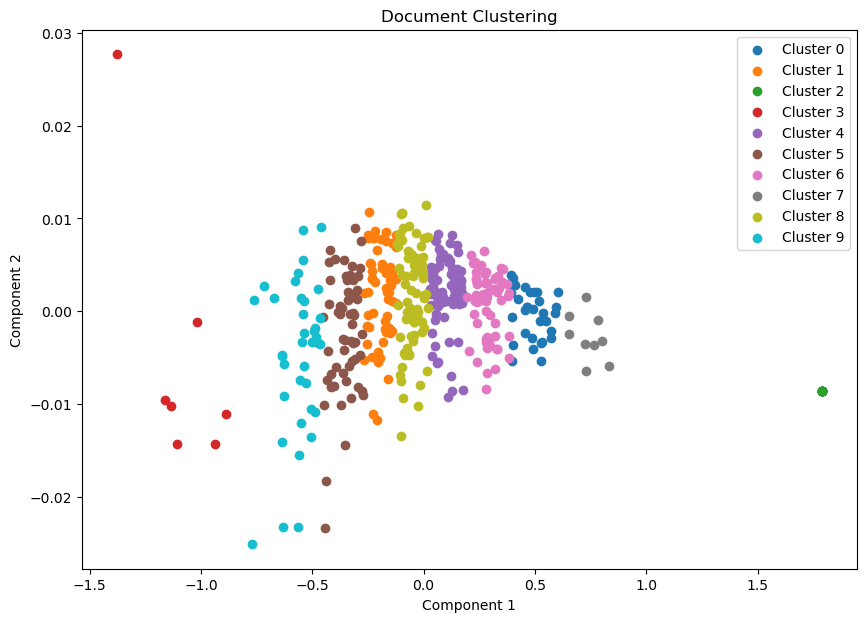

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Scaricare le risorse di NLTK necessarie
nltk.download('punkt')
nltk.download('stopwords')

documents = tutti_i_dati['Testo'].to_list()

# Esempio di documenti
'''documents = [
    "Questo è il primo documento.",
    "Questo documento è il secondo documento.",
    "E questo è il terzo documento.",
    "Il quarto documento è qui."
]'''

# Pre-processamento: tokenizzazione, rimozione stopwords e punteggiatura
stop_words = set(stopwords.words('italian'))
def preprocess(document):
    tokens = word_tokenize(document.lower())
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

processed_docs = [preprocess(doc) for doc in documents]

# Allenamento del modello Word2Vec
model = Word2Vec(sentences=processed_docs, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

# Calcolare i document embeddings
def document_embedding(document, model):
    valid_words = [word for word in document if word in model.wv.key_to_index]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in valid_words], axis=0)

document_embeddings = np.array([document_embedding(doc, model) for doc in processed_docs])

# Applicare KMeans
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(document_embeddings)
labels = kmeans.labels_

# Riduzione della dimensionalità con PCA o TSNE
# Usare PCA
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(document_embeddings)

# Alternativa: usare TSNE
# tsne = TSNE(n_components=2, random_state=0)
# reduced_embeddings = tsne.fit_transform(document_embeddings)

# Plotting
plt.figure(figsize=(10, 7))
for i in range(num_clusters):
    points = reduced_embeddings[labels == i]
    plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {i}")

plt.title("Document Clustering")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

In [18]:
pd.set_option('display.max_rows', None)

# Funzione per ottenere parole simili e filtrare i risultati per includere "manifestazione" con un punteggio sopra una soglia
def most_similar_filtered(model, positive, score_threshold=0.9, filter_term="manifestazione", topn=1000):
    results = []
    for word in positive:
        try:
            # Ottieni parole simili per la parola corrente
            similar_words = model.wv.most_similar(positive=[word], topn=topn)
            
            # Cerca se "manifestazione" è tra i risultati con un punteggio sopra la soglia
            for similar_word, score in similar_words:
                if similar_word == filter_term and score >= score_threshold:
                    results.append((word, similar_word, score))
        except KeyError:
            # La parola non è presente nel modello, continua con la prossima
            print(f"Parola '{word}' non presente nel modello.")
            continue
    
    return results

# Lista di parole positive
positive_words = intersezione

# Converti tutte le stringhe in minuscolo
positive_words_lower = [s.lower() for s in positive_words]

# Ottieni i risultati filtrati con le parole convertite in minuscolo
filtered_similar_words = most_similar_filtered(model, positive=positive_words_lower, score_threshold=0.9, filter_term="manifestazione", topn=1000)

# Creare un DataFrame dai risultati filtrati
df = pd.DataFrame(filtered_similar_words, columns=["Parola Chiave", "Simile a", "Punteggio"])

df

Parola 'valle agricola' non presente nel modello.
Parola 'castel san pietro terme' non presente nel modello.
Parola 'sala baganza' non presente nel modello.
Parola 'castelfranco veneto' non presente nel modello.
Parola 'cerreto d'esi' non presente nel modello.
Parola 'serra san quirico' non presente nel modello.
Parola 'torre santa susanna' non presente nel modello.
Parola 'castel maggiore' non presente nel modello.
Parola 'cervia' non presente nel modello.
Parola 'romans d'isonzo' non presente nel modello.
Parola 'mercato saraceno' non presente nel modello.
Parola 'martina franca' non presente nel modello.
Parola 'san lorenzo' non presente nel modello.
Parola 'dolo' non presente nel modello.
Parola 'predaia' non presente nel modello.
Parola 'cassano delle murge' non presente nel modello.
Parola 'muro leccese' non presente nel modello.
Parola 'castellana grotte' non presente nel modello.
Parola 'san severo' non presente nel modello.
Parola 'san vito dei normanni' non presente nel model

,Parola Chiave,Simile a,Punteggio
0,agrigento,manifestazione,0.966605
1,alessano,manifestazione,0.910358
2,casalbordino,manifestazione,0.960384
3,lenta,manifestazione,0.954074
4,bolzano,manifestazione,0.955132
5,cori,manifestazione,0.911218
6,flumeri,manifestazione,0.973144
7,troia,manifestazione,0.986069
8,arezzo,manifestazione,0.996182
9,conselice,manifestazione,0.923907


In [19]:
import pandas as pd

# Funzione per ottenere parole simili e filtrare i risultati per includere "manifestazione" e "corteo" con un punteggio sopra una soglia
def most_similar_filtered(model, positive, score_threshold=0.9, filter_terms=["corteo", "manifestazione"], topn=1000):
    results_raduno = []
    results_manifestazione = []
    for word in positive:
        try:
            # Ottieni parole simili per la parola corrente
            similar_words = model.wv.most_similar(positive=[word], topn=topn)
            
            # Cerca se una delle parole filtro è tra i risultati con un punteggio sopra la soglia
            for similar_word, score in similar_words:
                if similar_word in filter_terms and score >= score_threshold:
                    if similar_word == "corteo":
                        results_raduno.append((word, score))
                    elif similar_word == "manifestazione":
                        results_manifestazione.append((word, score))
        except KeyError:
            # La parola non è presente nel modello, continua con la prossima
            print(f"Parola '{word}' non presente nel modello.")
            continue
    
    return results_raduno, results_manifestazione

# Lista di parole positive
positive_words = intersezione

# Converti tutte le stringhe in minuscolo
positive_words_lower = [s.lower() for s in positive_words]

# Ottieni i risultati filtrati con le parole convertite in minuscolo
results_corteo, results_manifestazione = most_similar_filtered(model, positive=positive_words_lower, score_threshold=0.9, filter_terms=["corteo", "manifestazione"], topn=1000)

# Creare un DataFrame dai risultati filtrati
df_corteo = pd.DataFrame(results_corteo, columns=["Parola Chiave", "Punteggio per Corteo"])
df_manifestazione = pd.DataFrame(results_manifestazione, columns=["Parola Chiave", "Punteggio per Manifestazione"])

# Unire i due DataFrame basati sulla colonna "Parola Chiave"
df = pd.merge(df_corteo, df_manifestazione, on="Parola Chiave", how="outer")

df

Parola 'valle agricola' non presente nel modello.
Parola 'castel san pietro terme' non presente nel modello.
Parola 'sala baganza' non presente nel modello.
Parola 'castelfranco veneto' non presente nel modello.
Parola 'cerreto d'esi' non presente nel modello.
Parola 'serra san quirico' non presente nel modello.
Parola 'torre santa susanna' non presente nel modello.
Parola 'castel maggiore' non presente nel modello.
Parola 'cervia' non presente nel modello.
Parola 'romans d'isonzo' non presente nel modello.
Parola 'mercato saraceno' non presente nel modello.
Parola 'martina franca' non presente nel modello.
Parola 'san lorenzo' non presente nel modello.
Parola 'dolo' non presente nel modello.
Parola 'predaia' non presente nel modello.
Parola 'cassano delle murge' non presente nel modello.
Parola 'muro leccese' non presente nel modello.
Parola 'castellana grotte' non presente nel modello.
Parola 'san severo' non presente nel modello.
Parola 'san vito dei normanni' non presente nel model

,Parola Chiave,Punteggio per Corteo,Punteggio per Manifestazione
0,agrigento,0.967750,0.966605
1,alessano,0.909850,0.910358
2,casalbordino,0.960577,0.960384
3,lenta,0.954249,0.954074
4,bolzano,0.956158,0.955132
5,cori,0.909560,0.911218
6,flumeri,0.972834,0.973144
7,troia,0.985816,0.986069
8,arezzo,0.995955,0.996182
9,conselice,0.924125,0.923907


In [20]:
intersezione = df['Parola Chiave'].to_list()
intersezione

['agrigento',
 'alessano',
 'casalbordino',
 'lenta',
 'bolzano',
 'cori',
 'flumeri',
 'troia',
 'arezzo',
 'conselice',
 'pisa',
 'melegnano',
 'orvieto',
 'nociglia',
 'predappio',
 'udine',
 'battipaglia',
 'portici',
 'chieti',
 'capaci',
 'aversa',
 'formello',
 'cassino',
 'acerra',
 'cesena',
 'rieti',
 'lanciano',
 'ravenna',
 'conegliano',
 'opera',
 'bologna',
 'licata',
 'lodi',
 'milazzo',
 'rimini',
 'ponte',
 'premilcuore',
 'venezia',
 'mese',
 'lucera',
 'mattinata',
 'lomazzo',
 'lecce',
 'rovigo',
 'forlì',
 'colonna',
 'parma',
 'forlimpopoli',
 'perugia',
 'modena',
 'pontecorvo',
 'leverano',
 'ruffano',
 'tarquinia',
 'pavia',
 'taranto',
 'menfi',
 'ancona',
 'caserta',
 'canicattì',
 'capena',
 'comacchio',
 'trinitapoli',
 'meldola',
 'napoli',
 'latina',
 'bari',
 'vita',
 'vasto',
 'sciacca',
 'milano',
 'fasano',
 'cadoneghe',
 'treviso',
 'valmontone',
 'novara',
 'frosinone',
 'cellole',
 'lago',
 'faenza',
 'bianco',
 'sale',
 'carovigno',
 'brindisi',
 

In [22]:
it = pd.read_csv('..\IT.txt', sep='\t', header=None)

In [23]:
it = it.rename(columns={1: 'droppare', 2: 'Comune', 3: 'Regione', 4: 'codice_regione', 9: 'Lat', 10: 'Long'})
it = it.drop(columns=['droppare'])
it_filtrato = it[['Comune', 'Regione', 'codice_regione', 'Lat', 'Long']]
#it_filtrato

In [24]:
it_distinct = it_filtrato.drop_duplicates()
it_distinct["Comune"] = it_distinct["Comune"].str.lower()
#it_distinct

In [25]:
intersezione_df = pd.DataFrame(intersezione, columns=['Comune'])
#intersezione_df

In [26]:
df_inner = pd.merge(it_distinct, intersezione_df, on='Comune', how='inner')
#df_inner

In [27]:
import altair as alt

urlGeo='https://raw.githubusercontent.com/openpolis/geojson-italy/master/topojson/limits_IT_all.topo.json'
italyGeoRegions=alt.topo_feature(urlGeo,'regions')

italyBaseMap=alt.Chart(italyGeoRegions).mark_geoshape(
    fill='lightgray', stroke='black', strokeWidth=1
)

italyBaseMap

alt.Chart(...)

alt.LayerChart(...)
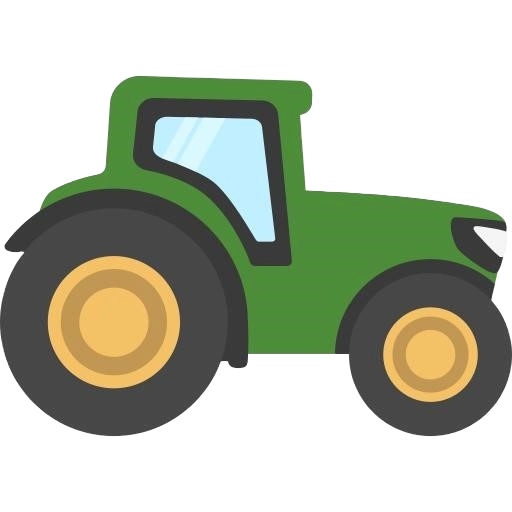

In [31]:
import altair as alt
import pandas as pd
import base64
from io import BytesIO
from PIL import Image

# Funzione per convertire l'immagine in una stringa base64
def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Converti l'immagine locale in base64
image_path = "file.png"
base64_image = image_to_base64(image_path)
image_url = f"data:image/png;base64,{base64_image}"

bubbles=alt.Chart(df_inner).mark_image(
    url=image_url,
    width=20,
    height=20
).encode(
        latitude='Lat:Q',
        longitude='Long:Q',
        tooltip='Comune:N'
        #size='superficie totale - ettari:Q' # come fare i pallini più grandi (hint: cerco range nella documentazione)

    )

(italyBaseMap + bubbles).properties(width=600,height=600)

In [32]:
# Conta le occorrenze distinte nella colonna 'A' e trasforma il risultato in un DataFrame
df_count = df_inner['Regione'].value_counts().reset_index()

# Rinomina le colonne del nuovo DataFrame
df_count.columns = ['Regione', 'Conteggio']
df_count['Regione'] = df_count['Regione'].replace(['Abruzzi'],['Abruzzo'])
df_count

,Regione,Conteggio
0,Emilia-Romagna,23
1,Puglia,19
2,Lazio,17
3,Campania,16
4,Lombardia,14
5,Sicilia,10
6,Veneto,8
7,Abruzzo,7
8,Toscana,7
9,Calabria,6


In [33]:
import pandas as pd
import requests

# Lista delle regioni italiane
regioni_italiane = [
    'Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
    'Friuli-Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
    'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana',
    'Trentino-Alto Adige', 'Umbria', 'Valle d\'Aosta', 'Veneto'
]

# Funzione per ottenere le coordinate geografiche utilizzando un servizio di geocodifica (es. Nominatim di OpenStreetMap)
def ottieni_coordinate(regione):
    url = f"https://nominatim.openstreetmap.org/search.php?q={regione}, Italy&format=json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:
            lat = data[0]['lat']
            lon = data[0]['lon']
            return {'Regione': regione, 'lat': lat, 'long': lon}
    return None

# Creazione del DataFrame delle coordinate geografiche delle regioni italiane
coordinate_regioni = [ottieni_coordinate(regione) for regione in regioni_italiane]
coordinate_df = pd.DataFrame(coordinate_regioni)

# Visualizza il DataFrame
coordinate_df

,Regione,lat,long
0,Abruzzo,42.227681,13.854983
1,Basilicata,40.500571,16.081953
2,Calabria,39.0565974,16.5249864
3,Campania,40.860672,14.843984
4,Emilia-Romagna,44.525696,11.039437
5,Friuli-Venezia Giulia,46.151042,13.055904
6,Lazio,41.9808038,12.7662312
7,Liguria,44.4777617,8.7026296
8,Lombardia,45.5703694,9.7732524
9,Marche,43.3458388,13.1415872


In [34]:
import pandas as pd
import altair as alt

# Creazione di un DataFrame di esempio con i codici ISTAT delle regioni italiane
dati = {
    'Regione': ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna', 'Friuli-Venezia Giulia',
                'Lazio', 'Liguria', 'Lombardia', 'Marche', 'Molise', 'Piemonte', 'Puglia', 'Sardegna',
                'Sicilia', 'Toscana', 'Trentino-Alto Adige', 'Umbria', "Valle d'Aosta", 'Veneto'],
    'codice_regione': [13, 17, 18, 15, 8, 6, 12, 7, 3, 11, 14, 1, 16, 20, 19, 9, 4, 10, 2, 5]
}

df_codice_regione = pd.DataFrame(dati)
df_codice_regione

,Regione,codice_regione
0,Abruzzo,13
1,Basilicata,17
2,Calabria,18
3,Campania,15
4,Emilia-Romagna,8
5,Friuli-Venezia Giulia,6
6,Lazio,12
7,Liguria,7
8,Lombardia,3
9,Marche,11


In [35]:
df_final = df_count.merge(coordinate_df, on='Regione', how='right')
df_final_2 = df_final.merge(df_codice_regione, on='Regione', how='inner')
df_final_2

,Regione,Conteggio,lat,long,codice_regione
0,Abruzzo,7.0,42.227681,13.854983,13
1,Basilicata,1.0,40.500571,16.081953,17
2,Calabria,6.0,39.0565974,16.5249864,18
3,Campania,16.0,40.860672,14.843984,15
4,Emilia-Romagna,23.0,44.525696,11.039437,8
5,Friuli-Venezia Giulia,2.0,46.151042,13.055904,6
6,Lazio,17.0,41.9808038,12.7662312,12
7,Liguria,1.0,44.4777617,8.7026296,7
8,Lombardia,14.0,45.5703694,9.7732524,3
9,Marche,1.0,43.3458388,13.1415872,11


In [36]:
df_final_2["Conteggio"].fillna(0, inplace=True)
df_final_2

,Regione,Conteggio,lat,long,codice_regione
0,Abruzzo,7.0,42.227681,13.854983,13
1,Basilicata,1.0,40.500571,16.081953,17
2,Calabria,6.0,39.0565974,16.5249864,18
3,Campania,16.0,40.860672,14.843984,15
4,Emilia-Romagna,23.0,44.525696,11.039437,8
5,Friuli-Venezia Giulia,2.0,46.151042,13.055904,6
6,Lazio,17.0,41.9808038,12.7662312,12
7,Liguria,1.0,44.4777617,8.7026296,7
8,Lombardia,14.0,45.5703694,9.7732524,3
9,Marche,1.0,43.3458388,13.1415872,11


In [ ]:
apiCovid='https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
df=pd.read_csv(apiCovid, parse_dates=['data'])[['denominazione_regione', 'codice_regione', 'lat', 'long']].drop_duplicates()
df

In [ ]:
df_final = df.merge(df_count, on='denominazione_regione', how='inner')
df_final

In [37]:
alt.Chart(italyGeoRegions).mark_geoshape(
    stroke='#fff', strokeWidth=0.25
).transform_lookup(
    lookup='properties.reg_istat_code_num', from_=alt.LookupData(data=df_final_2, key='codice_regione', fields=['Regione', 'Conteggio'])
).encode(
    color= alt.Color('Conteggio:Q', scale=alt.Scale(scheme='oranges', type='quantize')),
    tooltip= [
              alt.Tooltip('Conteggio:Q'),
              alt.Tooltip('Regione:N')
              #alt.Tooltip('data:N')
    ]
).project(
    type='mercator'
).properties(
    width=400,
    height=400
).configure_view(
    stroke=None
)

alt.Chart(...)

## Word Cloud con altair

In [93]:
import altair as alt
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import HBox, VBox, Layout
import warnings
warnings.filterwarnings("ignore")

# Sample DataFrame with longer category names
df = tutti_i_dati

# Dropdown options (list of Territorio)
dropdown_options = sorted(df['Edizione'].unique().tolist())

# Function to update chart1 based on selected category
def update_chart1(Edizione):
    filtered_df = df[df['Edizione'] == Edizione]

    Testo = filtered_df['Testo'].to_list()
    tokens = get_file_tokens(Testo)
    filtered_t = filter_words(normalize_words(tokens))
    stemmed = stem_words(filtered_t)
    stem_mapping = get_stem_mapping(filtered_t)
    destemmed = destem_words(stemmed, stem_mapping)
    c = Counter(destemmed)

    generate_tag_cloud(c)

    c_df = pd.DataFrame(list(c.items()), columns=['Word', 'Count'])

    # Sort the DataFrame by the 'Count' column in descending order
    df_sorted = c_df.sort_values(by='Count', ascending=False)

    # Select the top 20 rows
    top_20 = df_sorted.head(20)

    chart = alt.Chart(top_20).mark_bar().encode(
        x = 'Count:Q',
        y = alt.Y('Word:N', title='Word', sort='-x'),
        size=alt.Size(field='Count', type='quantitative', bin=alt.BinParams(maxbins=5)),
        color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues')),
        tooltip=['Word', 'Count']
    )
    
    display(chart)

    '''nltk_text = nltk.Text(tokens)
    nltk_text.dispersion_plot(top_20['Word'].to_list())'''

dropdown_edizione = widgets.Dropdown(
    options=dropdown_options,
    value=dropdown_options[0],  # Set initial value
    description='Select Edizione:',
    style={'description_width': 'initial'}  # Set description width to full
)  

# Initial display of charts and dropdowns side by side
output1 = widgets.Output()

with output1:
    display(VBox([dropdown_edizione]))
    update_chart1(dropdown_edizione.value)

# Arrange the outputs (charts) horizontally using HBox layout
display(output1)

# Set up event handlers for dropdowns
def on_edizione_change(change):
    with output1:
        clear_output(wait=True)
        display(VBox([dropdown_edizione]))
        update_chart1(change.new)

dropdown_edizione.observe(on_edizione_change, names='value')

Output()

In [119]:
import altair as alt
import pandas as pd
import random

# Esempio di dati: frequenze delle parole
#word_freq = {
#    "word": ["Python", "Data", "Science", "Machine", "Learning", "AI", "Altair", "Visualization", "Big", "Data"],
#    "frequency": [120, 100, 90, 80, 70, 60, 50, 40, 30, 20]
#}

Testo = tutti_i_dati['Testo'].to_list()
tokens = get_file_tokens(Testo)
filtered_t = filter_words(normalize_words(tokens))
stemmed = stem_words(filtered_t)
stem_mapping = get_stem_mapping(filtered_t)
destemmed = destem_words(stemmed, stem_mapping)
c = dict(Counter(destemmed))

# Conversione in DataFrame
df = pd.DataFrame.from_dict(c, orient='index', columns=['frequency'])

# Reset dell'indice per avere le parole come colonna
df.reset_index(inplace=True)

# Rinomina delle colonne
df.columns = ['word', 'frequency']

df = df.sort_values('frequency', ascending=False)[:100]

# Aggiungere posizioni casuali per x e y
random.seed(42)  # Per la riproducibilità
df['x'] = [random.uniform(0, 1) for _ in range(len(df))]
df['y'] = [random.uniform(0, 1) for _ in range(len(df))]

# Creare una visualizzazione con sfere proporzionali alla frequenza delle parole
circles = alt.Chart(df).mark_circle().encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=(0, 1)), title=None),
    y=alt.Y('y:Q', scale=alt.Scale(domain=(0, 1)), title=None),
    size=alt.Size('frequency:Q', scale=alt.Scale(range=[1000, 10000]), legend=None),
    color=alt.Color('word:N', legend=None),
    tooltip=['word:N', 'frequency:Q']
)

# Aggiungere le parole all'interno delle sfere
text = alt.Chart(df).mark_text(
    align='center',
    baseline='middle',
    fontSize=8
).encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=(0, 1)), title=None),
    y=alt.Y('y:Q', scale=alt.Scale(domain=(0, 1)), title=None),
    text='word:N',
    size=alt.value(10),  # Dimensione del testo fissa per tutte le parole
    tooltip=['word:N', 'frequency:Q']
)

# Unire le sfere e il testo
word_cloud = alt.layer(circles, text).properties(
    width=800,
    height=400,
    title='Word Cloud with Spheres'
).configure_axis(
    grid=False,
    domain=False,
    ticks=False,
    labels=False
).configure_view(
    strokeWidth=0
)

word_cloud

alt.LayerChart(...)